# Homework - 2 Practical Deep Learning Sys. Perf. - (CS4090) Chandan Suri

## Problem 1

1. You need to implement the perceptron algorithm without regularization (don’t use any existing im- plementation of perceptron), train it on the 20 points above, and test its accuracy on 1000 randomly generated points inside the unit square. Generate the test points using the same procedure as the training points. You need to have your own implementation of the perceptron algorithm.

## Solution 1.1

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Generating Data
np.random.seed(2121)

train_x_1 = np.random.rand(20)
train_x_2 = np.random.rand(20)
train_x = np.column_stack((train_x_1, train_x_2))
train_y = (train_x_1 > train_x_2).astype(int)
# As the predictions would be sign of W.X, we need to convert these labels in the form of 1 and -1 (as signs!)
train_y[train_y == 0] = -1

test_x_1 = np.random.rand(1000)
test_x_2 = np.random.rand(1000)
test_x = np.column_stack((test_x_1, test_x_2))
test_y = (test_x_1 > test_x_2).astype(int)
# As the predictions would be sign of W.X, we need to convert these labels in the form of 1 and -1 (as signs!)
test_y[test_y == 0] = -1


In [3]:
num_epochs = 3
from sklearn.metrics import accuracy_score

def simple_perceptron(train_x, labels):
    weights = np.zeros(len(train_x[0]))
    eta = 0.6
    for epoch in range(num_epochs):
        for input_idx in range(len(train_x)):
            if labels[input_idx] * np.dot(weights, train_x[input_idx]) <= 0:
                weights += eta * train_x[input_idx] * labels[input_idx]
                
    return weights

# Training the model
weights = simple_perceptron(train_x, train_y)
print(f"Weights are: {weights}")

# Testing the model on the test data
y_preds = []
for test_x_data in test_x:
    y_hat = np.dot(weights, test_x_data)
    y_preds.append(np.sign(y_hat))
    
y_preds = np.asarray(y_preds)
accuracy = accuracy_score(y_preds, test_y)
print(f"Accuracy for Simple Perceptron Model is : {accuracy}")


Weights are: [ 0.36554712 -0.55944132]
Accuracy for Simple Perceptron Model is : 0.842




2. Change the perceptron criterion to hinge-loss in your implementation for training, and repeat the accuracy computation on the same test points above. Regularization is not used.

## Solution 1.2

In [5]:
def perceptron_with_hinge_loss(train_x, labels):
    weights = np.zeros(len(train_x[0]))
    eta = 0.6
    for epoch in range(1, num_epochs + 1):
        for input_idx in range(len(train_x)):
            if labels[input_idx] * np.dot(weights, train_x[input_idx]) < 1:
                weights += eta * (train_x[input_idx] * labels[input_idx] + (-2 * (1/epoch) * weights))
            else:
                weights += eta * (-2 * (1/epoch) * weights)
                
    return weights

# Training the model
weights = perceptron_with_hinge_loss(train_x, train_y)
print(f"Weights with Hinge Loss are: {weights}")

# Testing the model on the test data
y_preds = []
for test_x_data in test_x:
    y_hat = np.dot(weights, test_x_data)
    y_preds.append(np.sign(y_hat))
    
y_preds = np.asarray(y_preds)
accuracy = accuracy_score(y_preds, test_y)
print(f"Accuracy for Perceptron Model with Hinge Loss is : {accuracy}")


Weights with Hinge Loss are: [ 0.26700903 -0.25037377]
Accuracy for Perceptron Model with Hinge Loss is : 0.972





3. In which case do you obtain better accuracy and why?

## Solution1.3

<font color = "blue">I get better accuracy for the case when I have used the hinge loss rather than the simple perceptron model. Precisely, this was expected as the hinge loss is generally better at classification as it tries to find the best line where we can separate the classes and where we can have the meaximum separation between the classes. Due to this, we have a better accuracy here in the case of hinge loss.</font>



4. In which case do you think that the classification of the same 1000 test instances will not change significantly by using a different set of 20 training points?

## Solution 1.4

<font color = "blue">According to me, in the case of hinge loss, the classification of the same 1000 test instances won't change significantly by using different set of 20 training points. This is so because according to the hinge loss criterion, while training, we try to find the decision boundary where we can have the maximum separation between the classified classes. On the other hand, in the case of the simple perceptron model, the decision boundary is not calculated that way and thus, depends more on the training set data as compared to the hinge loss. </font>

-------------------------------------------------------------------------------------------------------------------

## Problem 2

1. Explain vanishing gradients phenomenon using standard normalization with different values of standard deviation and tanh and sigmoid activation functions. Then show how Xavier (aka Glorot normal) initialization of weights helps in dealing with this problem. Next use ReLU activation and show that instead of Xavier initialization, He initialization works better for ReLU activation. You can plot activations at each of the 5 layers to answer this question.

## Solution 2.1

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras import backend as K

from matplotlib import pyplot as plt
from matplotlib import rcParamsDefault


def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.

    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.

    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def create_cnn_model(input_shape, num_classes, kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'):
    """Create CNN model similar to
       https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def compile_model(model):
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
    return model


def get_init_id(init):
    """
    Returns string ID summarizing initialization scheme and its parameters.

    Args:
        init: Instance of some initializer from keras.initializers.
    """
    try:
        init_name = str(init).split('.')[2].split(' ')[0]
    except:
        init_name = str(init).split(' ')[0].replace('.', '_')

    param_list = []
    config = init.get_config()
    for k, v in config.items():
        if k == 'seed':
            continue
        param_list.append('{k}-{v}'.format(k=k, v=v))
    init_params = '__'.join(param_list)

    return '|'.join([init_name, init_params])


def get_activations(model, x, mode=0.0):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x, mode])
    return output_elts


class LossHistory(keras.callbacks.Callback):
    """A custom keras callback for recording losses during network training."""

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))
        

In [ ]:
import seaborn as sns
from keras import initializers
from keras.datasets import mnist


In [ ]:
# Network To Train Params
hidden_layers_num = 5
nodes_in_layer = 100
batch_size = 1000
epochs = 1

# MNIST Dataset Related
train_num = 60000
test_num = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
classes_num = len(np.unique(y_test))
pixels_num_data = 28*28

x_train = x_train.reshape(train_num, pixels_num_data).astype('float32')[:train_num]
x_test = x_test.reshape(test_num, pixels_num_data).astype('float32')[:test_num]
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, classes_num)
y_test = keras.utils.to_categorical(y_test, classes_num)


In [ ]:
def draw_activations_plots(rows_activations, sigmas, initializer_type, activation_func_name):
  df = pd.DataFrame(rows_activations, columns=['Hidden Layer', 'Standard Deviation', 'Output'])
  fig = plt.figure(figsize=(12, 4*len(sigmas)))
  axes = grid_axes_it(len(sigmas), 1, fig=fig)

  for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    if initializer_type == "Random Normal":
      ax.set_title('Activations Drawn from $N(\mu = 0, \sigma = {%.4f})$' % sig, fontsize=13)
    elif initializer_type == "Xavier" or initializer_type == "He":
      ax.set_title(f'Activations Drawn from {initializer_type} Initialization', fontsize=12)
    
    if (len(sigmas) > 1 and sig == sigmas[1]) or len(sigmas) == 1:
      ax.set_ylabel(f"{activation_func_name} Neuron Outputs")
    if sig != sigmas[-1]:
      ax.set_xticklabels(())
    else:
      ax.set_xlabel("Hidden Layer")

  plt.tight_layout()
  plt.show()

def create_and_train_model(rows, stddev, init_handler, activation_func):
  model = create_mlp_model(hidden_layers_num, nodes_in_layer, (pixels_num_data,), classes_num, init_handler, 'zeros', activation_func)
  compile_model(model)
  model.fit(x_train, y_train, epochs=epochs, verbose = 0, batch_size=batch_size)

  output_elts = get_activations(model, x_test)
  n_layers = len(model.layers)
  i_output_layer = n_layers - 1

  for i, out in enumerate(output_elts[:-1]):
    if i > 0 and i != i_output_layer:
      for out_i in out.ravel()[::20]:
        rows.append([i, stddev, out_i])

  return rows

In [ ]:
def run_model_and_get_activations_results(sigmas, initializer_type, activation_func, activation_func_name):
  rows_activations = []

  if initializer_type == "Random Normal":
    for stddev in sigmas:
      init_handler = initializers.RandomNormal(mean=0.0, stddev=stddev)
      rows_activations = create_and_train_model(rows_activations, stddev, init_handler, activation_func)
  elif initializer_type == "Xavier":
    init_handler = initializers.glorot_normal()
    rows_activations = create_and_train_model(rows_activations, sigmas[0], init_handler, activation_func)
  elif initializer_type == "He":
    init_handler = initializers.he_normal()
    rows_activations = create_and_train_model(rows_activations, sigmas[0], init_handler, activation_func)
  else:
    print("Wrong Initialzer Type!!!")
    return None
  
  draw_activations_plots(rows_activations, sigmas, initializer_type, activation_func_name)


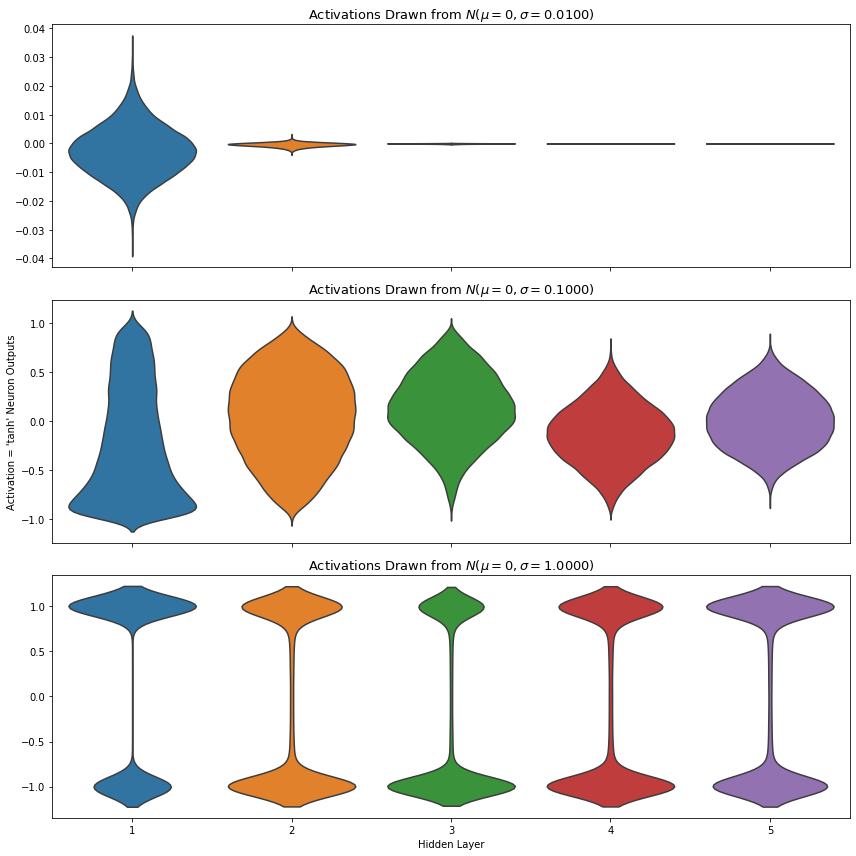

In [ ]:
rows_activations = run_model_and_get_activations_results([0.01, 0.1, 1], "Random Normal", 'tanh', 'Activation = \'tanh\'')

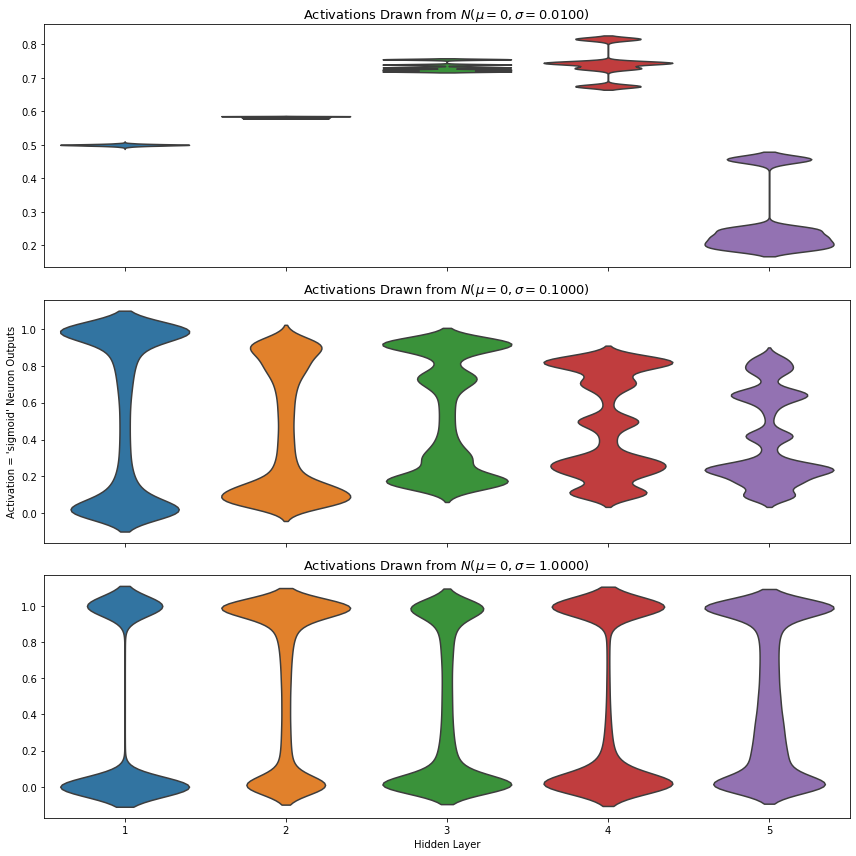

In [ ]:
run_model_and_get_activations_results([0.01, 0.1, 1], "Random Normal", 'sigmoid', 'Activation = \'sigmoid\'')

<font color="blue">
    As we can see above for both the 'tanh' and 'sigmoid' activation, we get vanishing gradients for the case when sigma is 0.01 which is quite far off from the sigma of 0.1 at which both of them run fine. On the other hand, a sigma of 1 gives us exploding gradients for both the activations shown above. We also see that the problem of vanishing and exploding gradients depends on the weights initializer and in the case of random normal initializer, it depends upon the sigma value for that initializer. Moreover, sometimes, it could be very hard to find a sigma that gives you optimal results and where these problems don't arise.
    <br>The vanishing gradients here precisely mean (as you can see above) when the models seems to stop learning as the activations cover a very small range for the hidden layers which means that the gradients are in a vanishing fashion. This would mean that the model will either learn very slowly or it won't learn because the gradients have been vanishing which would mean that no weight updations will be done going forward. Precisely, this means that the model stops learning and you only get activations in a very small range or maybe you don't get any. This is clearly shown for the sigma of 0.01 for both the activations above. 
    <br> On the other hand, sigma of 1 for both the activations above gives us exploding gradients as you can see that the activations are mostly near the extremes for both the functions (extremes of their respective ranges). In the middle, you see a very thin line in the activations which means that because the gradients are really high, the activations computed are really high and there are very few activations that are near the mean of their range. This also affects the model's performance in a detrimental way and the model doesn't produce expected results.
</font>

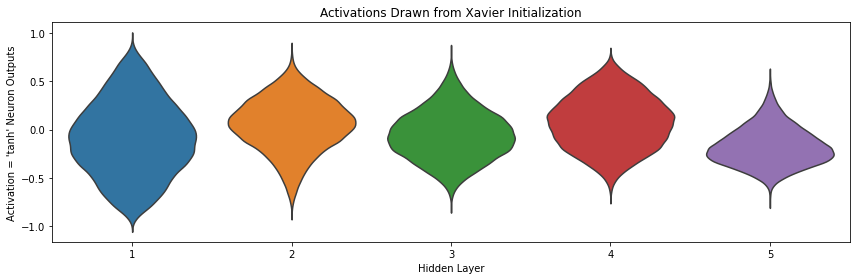

In [ ]:
# sigma is passed as a dummy, it's not used anywhere in this call
run_model_and_get_activations_results([1], "Xavier", 'tanh', 'Activation = \'tanh\'')

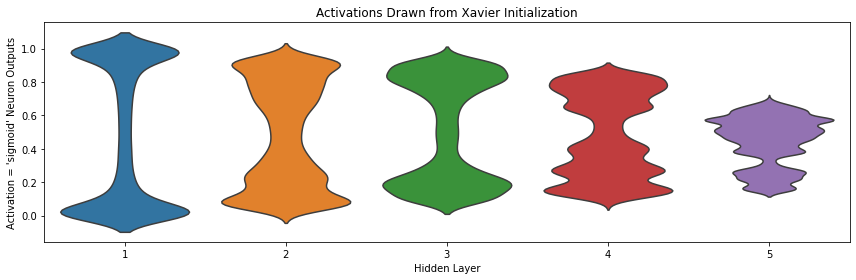

In [ ]:
# sigma is passed as a dummy, it's not used anywhere in this call
run_model_and_get_activations_results([1], "Xavier", 'sigmoid', 'Activation = \'sigmoid\'')

<font color = "blue">
    As you can see above, when we use the Xavier initialization for 'tanh' and 'sigmoid' activation functions, the problem of vanishing and exploding gradients vanishes. As mostly we are getting activations that are distributed over the full range such that it doesn't seem that the gradients are vanishing which would have resulted in the activations in a very small range rather than the full range of their activation values, this means that the Xavier initialization works better for the 'tanh' and 'sigmoid' activation functions.
</font>

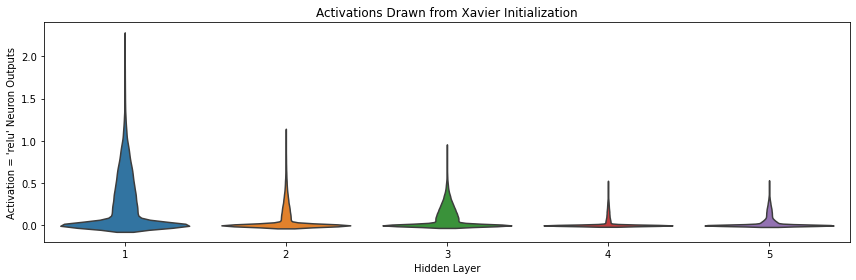

In [ ]:
# sigma is passed as a dummy, it's not used anywhere in this call
run_model_and_get_activations_results([1], "Xavier", 'relu', 'Activation = \'relu\'')

<font color="blue">
    As we can see above, the same initializer "Xavier" which was working great with the tanh and sigmoid functions, doesn't work well with the relu activation function. In the picture above, we can clearly see the problem of vanishing gradients as for the layers 2-5, we see a decrease in the range of values computed for the activations. This would precisely mean that the gradients computed for those layers in the backpropagation are vanishing which in turn, would produce such activations. 
</font>

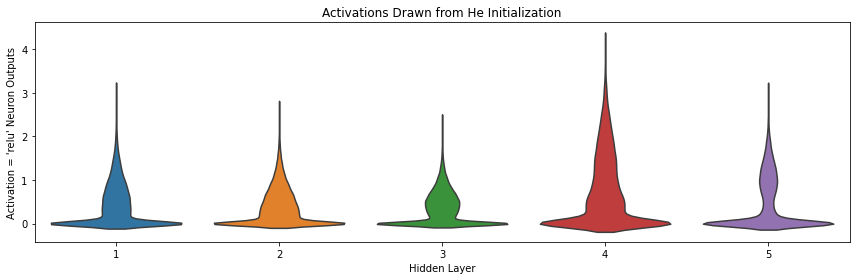

In [ ]:
# sigma is passed as a dummy, it's not used anywhere in this call
run_model_and_get_activations_results([1], "He", 'relu', 'Activation = \'relu\'')

<font color="blue">
    As we can see above, the problem of vanishing gradients is gone when we use the He Normal initializer with the relu activation function. The range of values for the activations computed here are not just near the value zero but have been computed till 3 or 4 for some of the layers and are covering a good range of activation values. This precisely means that the gradients computed aren't vanishing otherwise the activations computed would have been very less and near the zero value as in the case of Xavier initialization with the relu activation function. This clearly shows us that the He Normal initializer works better with the relu activation function as compared to the Xavier initialization for the same.
</font>

2. The dying ReLU is a kind of vanishing gradient, which refers to a problem when ReLU neurons become
inactive and only output 0 for any input. In the worst case of dying ReLU, ReLU neurons at a certain
layer are all dead, i.e., the entire network dies and is referred as the dying ReLU neural networks in
Lu et al (reference below). A dying ReLU neural network collapses to a constant function. Show this
phenomenon using any one of the three 1-dimensional functions in page 11 of Lu et al. Use a 10-layer
 ReLU network with width 2 (hidden units per layer). Use minibatch of 64 and draw training data
√√
uniformly from [− 7, 7]. Perform 1000 independent training simulations each with 3,000 training
points. Out of these 1000 simulations, what fraction resulted in neural network collapse. Is your answer close to over 90% as was reported in Lu et al. ?

## Solution 2.2

In [1]:
import keras
from keras import layers
import numpy as np
from keras import initializers

seed = 12121
np.random.seed(seed)

# Getting the training and testing data
train_data_num = 3000
train_data = np.random.uniform(-np.sqrt(7), np.sqrt(7), train_data_num)
train_data = train_data.reshape(-1, 1)
train_labels = train_data * np.sin(5*train_data)
train_labels = train_labels.reshape(-1, 1)

# Based on the insight from the question before, as we need to take relu activation function, 
# I am going to take the "HeNormal" as kernel initializer
def create_seq_model_with_layers(layers_num, hidden_units_per_layer, activation_func, kernel_initializer):
  model = keras.Sequential()

  for idx in range(layers_num-1):
    model.add(layers.Dense(hidden_units_per_layer, activation = activation_func, kernel_initializer = kernel_initializer))
  
  model.add(layers.Dense(1, activation = "linear"))
  model.build((1, 1))
  
  return model

In [23]:
def run_and_train_model(num_iterations):
  variances = []
  
  for iteration in range(num_iterations):
    print(f'Training for iteration: {iteration + 1}')
    model = create_seq_model_with_layers(10, 2, 'relu', initializers.he_normal())
    model.compile(loss = 'mse', optimizer = 'adam')
    train_history = model.fit(train_data, train_labels, epochs = 100, batch_size = 64, verbose = 0)
    variances.append(np.var(train_history.history['loss']))
  
  return variances

variances = run_and_train_model(1000)


Training for iteration: 1
Training for iteration: 2
Training for iteration: 3
Training for iteration: 4
Training for iteration: 5
Training for iteration: 6
Training for iteration: 7
Training for iteration: 8
Training for iteration: 9
Training for iteration: 10
Training for iteration: 11
Training for iteration: 12
Training for iteration: 13
Training for iteration: 14
Training for iteration: 15
Training for iteration: 16
Training for iteration: 17
Training for iteration: 18
Training for iteration: 19
Training for iteration: 20
Training for iteration: 21
Training for iteration: 22
Training for iteration: 23
Training for iteration: 24
Training for iteration: 25
Training for iteration: 26
Training for iteration: 27
Training for iteration: 28
Training for iteration: 29
Training for iteration: 30
Training for iteration: 31
Training for iteration: 32
Training for iteration: 33
Training for iteration: 34
Training for iteration: 35
Training for iteration: 36
Training for iteration: 37
Training f

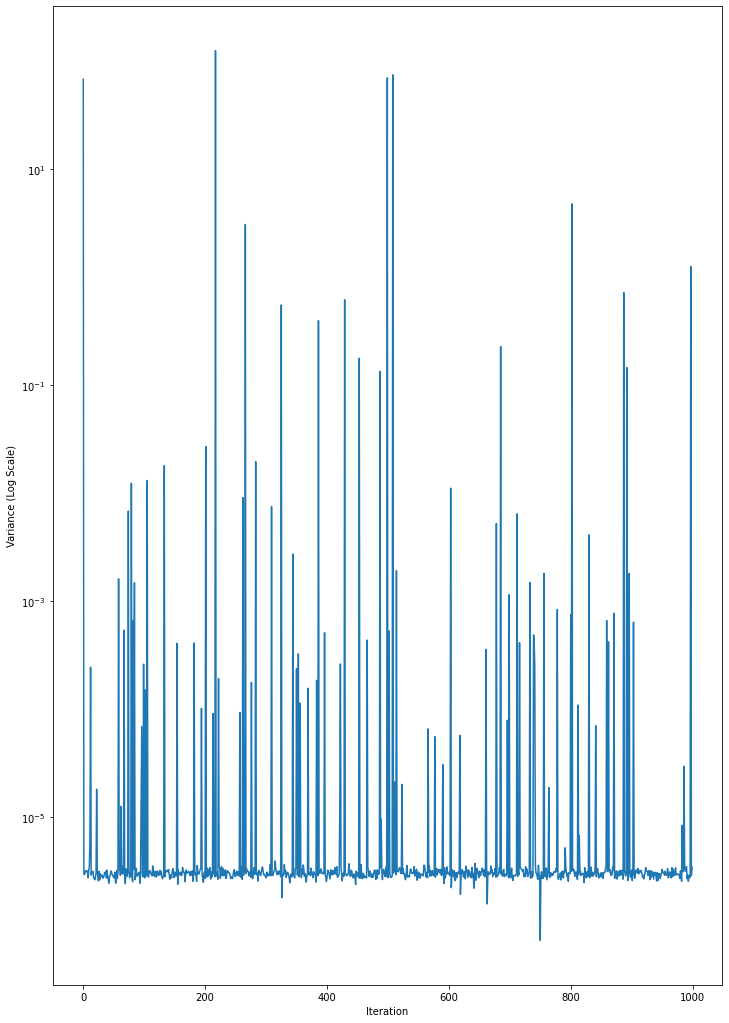

In [24]:
import matplotlib.pyplot as plt

# Showing the plot for all the losses over all the iterations
plt.plot(range(1000), variances)
plt.xlabel('Iteration')
plt.ylabel('Variance (Log Scale)')
plt.yscale('log')
plt.rcParams["figure.figsize"] = (12, 18)
plt.show()


<font color="blue">
    Firstly, let's draw the inference for what would dying ReLU network mean! It would mean that the model would stop learning as one of the layers have died in the model and has stopped learning. This, in turn would mean that the loss wouldn't decrease beyond a point and will remain stuck there. Moreover, this would mean that if you take the variance of all the loss values computed for a model over all the epochs, it would be very less value and the value would be either zero or very close to zero. Additionally, if you compute the log of that value, it would give you values way less than zero which would mean that the model had stopped learning at some point as one of the layers got dead and the network died because of that as it stopped learning anymore. 
    Going forward, when you do the above experiment for 1000 times with independent models, you should get the values of the log of the variances as very low (equal to zero or very less than zero). That's what precisely what I have done above. And as you can seem, for more than 90% of the time (might be even more than that), the values are less than or equal to zero and most of the values in there are less than 10^-5 which would mean that the value of variance was either zero or very close to the zero. This clearly is in line with the observations of Lu et al. As for more than 90% of the times, the problem of vanishing gradients can be seen above (or in worst case, dying ReLU network) when we consider the activation function to be relu. 
</font>

3. Instead of ReLU consider Leaky ReLU activation as defined below:
􏰁 z ifz>0 φ(z)= 0.01z ifz≤0. Run the 1000 training simulations in part 2 with Leaky ReLU activation and keeping everything else same. Again calculate the fraction of simulations that resulted in neural network collapse. Did Leaky ReLU help in preventing dying neurons ?

## Solution 2.3

In [2]:
from keras.layers import LeakyReLU
import keras
from keras import layers
import numpy as np
from keras import initializers

def create_seq_model_with_leaky_relu_layers(layers_num, hidden_units_per_layer, alpha_val, kernel_initializer):
  model = keras.Sequential()

  for idx in range(layers_num-1):
    model.add(layers.Dense(hidden_units_per_layer, kernel_initializer = kernel_initializer))
    model.add(LeakyReLU(alpha = alpha_val))
  
  model.add(layers.Dense(1, activation = "linear"))
  model.build((None, 1))

  return model


In [3]:
def run_and_train_model2(num_iterations):
  variances = []
  model = None
  train_history = None

  for iteration in range(num_iterations):
    print(f'Training for iteration: {iteration + 1}')
    model = create_seq_model_with_leaky_relu_layers(10, 2, 0.01, initializers.he_normal())
    model.compile(loss = 'mse', optimizer = 'adam')
    train_history = model.fit(train_data, train_labels, epochs = 100, batch_size = 64, verbose = 0)
    variances.append(np.var(train_history.history['loss']))
  
  return variances

variances = run_and_train_model2(1000)


Training for iteration: 1
Training for iteration: 2
Training for iteration: 3
Training for iteration: 4
Training for iteration: 5
Training for iteration: 6
Training for iteration: 7
Training for iteration: 8
Training for iteration: 9
Training for iteration: 10
Training for iteration: 11
Training for iteration: 12
Training for iteration: 13
Training for iteration: 14
Training for iteration: 15
Training for iteration: 16
Training for iteration: 17
Training for iteration: 18
Training for iteration: 19
Training for iteration: 20
Training for iteration: 21
Training for iteration: 22
Training for iteration: 23
Training for iteration: 24
Training for iteration: 25
Training for iteration: 26
Training for iteration: 27
Training for iteration: 28
Training for iteration: 29
Training for iteration: 30
Training for iteration: 31
Training for iteration: 32
Training for iteration: 33
Training for iteration: 34
Training for iteration: 35
Training for iteration: 36
Training for iteration: 37
Training f

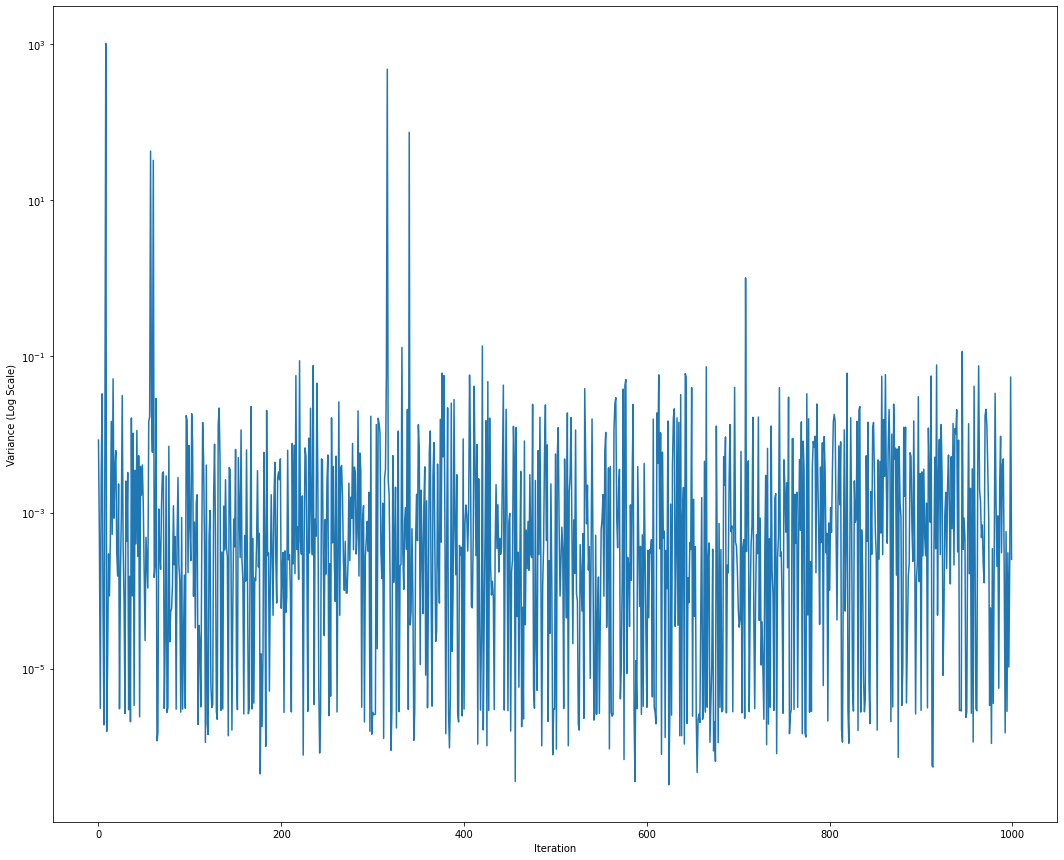

In [20]:
# Showing the plot for all the losses over all the iterations
import matplotlib.pyplot as plt

plt.plot(range(1000), variances)
plt.xlabel('Iteration')
plt.ylabel('Variance (Log Scale)')
plt.yscale('log')
plt.rcParams["figure.figsize"] = (18, 15)
plt.show()

<font color="blue">
    As I have explained in the question above (2.2) of why I have taken the variance as a parameter here and why have I taken the log of it, I will directly move to the inference that I draw from the graph above. From the graph above, we can clearly see that the model is learning for most of the cases as the variance values are not zero or very close to zero for most of the cases (this is analogous to the case when the log of the variance values is close to 10^-5). As we are getting variances greater than zero for most of the cases here, this clearly means that the Leaky ReLU performed better here and the dying ReLU network problem didn't arise here a lot. Using Leaky ReLU actually improved the model performance in general and enabled the model to learn well (decrease in loss). Thus, Leaky ReLU helped in preventing dying neurons.  
</font>

## Problem 3

1. Explain the terms co-adaptation and internal covariance-shift. Use examples if needed. You may need to refer to two papers mentioned below to answer this question.

## Solution 3.1

<font color="blue">
    Co-adaptation means that some neurons are highly dependent which might be a cause of overfitting the model. If those dependent neurons receive some input that would affect the dependent neurons too, due to the high co-dependency between the neurons, the model performance can be impacted which generally results in overfitting the model. This problem is generally resolved using the Dropout layers as the dropout layers associate some probability with the neurons that states whether a neuron in the model will be taken into consideration or will be dropped out during the training of the model for some iteration. Effectively, this hinders the co-dependency between the neurons in a model and thus prevents the model from overfitting a dataset (fitting too closely to the noise in the data). Thus, the model performance can be improved by using the dropout layers if the model performance is being hindered due to the overfitting which in turn is a result of the co-adaptation problem.
    <br>
    Internal Covariance-shift is the change in the distribution of the network activations due to change in the network parameters during the training. Generally, Batch Normalization is the solution to this problem in neural networks. Precisely, the deeper the network, there is more of a chance for a mess caused by the phenomenon known as internal covariance-shift. This is because neural networks learn and change their weights in a chain manner throughout the layers present in the model (neural network). This would happen when the connection between the output layer's results and that of the hidden nodes haven't been stabilized. This, in turn, could be a result of the continual inflation of the activation function's output. Thus, to counter this problem we need to establish and enhance the relationship between the hidden layer's outputs with that of the output layer. Effectively, this is done with the help of batch normalization as it stabilizes those relationships between the layers by scaling the data and keeping it scaled while training the network. In Batch Normalization, the inputs to any of the layers is normalized by taking  those inputs and transforming them using the mean and variance of the data in that mini-batch. After the network has been trained, the entire datasets mean and variance is used. Thus, the batch normalization is helpful in resolving the internal covariance-shift problem. (However, whether or not this is true, is debatable! 
    <br>
    References: 
    1. https://blog.paperspace.com/busting-the-myths-about-batch-normalization/ <br>
    2. https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338
    </font>


2. Batch normalization is traditionally used in hidden layers, for input layer standard normalization is used. In standard normalization the mean and standard deviation are calculated using the entire training dataset whereas in batch normalization these statistics are calculated for each mini-batch. Train LeNet-5 with standard normalization of input and batch normalization for hidden layers. What are the learned batch norm parameters for each layer ?

## Solution 3.2

In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras import activations
import keras

epochs = 100
batch_size = 1024

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

# Transform lables to one-hot encoding
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)


<font color="blue">
    I have taken the batch normalization layers to be after the activations which is different from the way it was done in the original paper for the batch normalization. Moreover, in practice generally, it's found that we should place the batch normalization after the activation layer as that gives better results, but this is also debatable for some of the cases.
    <br>
    Reference: https://blog.paperspace.com/busting-the-myths-about-batch-normalization/
</font>

In [ ]:
# Create the model with Layer Normalization for the input layer and Batch Normalization layer for all the hidden layer
model = Sequential()

model.add(layers.Input(shape = (28, 28, 1)))
model.add(LayerNormalization(trainable = True))

# Convolution Layer
model.add(layers.Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'tanh', padding = "same"))
model.add(BatchNormalization(trainable = True))

# Average Pooling Layer
model.add(layers.AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))

# Convolution Layer
model.add(layers.Conv2D(16, kernel_size = (5, 5), strides = (1, 1), activation = 'tanh', padding = "valid"))
model.add(BatchNormalization(trainable = True))

# Average Pooling Layer
model.add(layers.AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))

# Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size = (5, 5), strides = (1, 1), activation = 'tanh', padding = "valid"))
model.add(BatchNormalization(trainable = True))

# Flatten the CNN output
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(84))
model.add(BatchNormalization(trainable = True))

# Output Layer
model.add(layers.Dense(10, activation = "softmax"))

# Compile a model
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test), verbose = 1)
scores = model.evaluate(x_test, y_test)
print(f"Test Loss : {scores[0]}, Accuracy = {scores[1]*100}%")

Epoch 1/100
59/59 [==============================] - 8s 119ms/step - loss: 2.2050 - accuracy: 0.2652 - val_loss: 2.4012 - val_accuracy: 0.1009
Epoch 2/100
59/59 [==============================] - 7s 113ms/step - loss: 2.1580 - accuracy: 0.3103 - val_loss: 2.3568 - val_accuracy: 0.1009
Epoch 3/100
59/59 [==============================] - 7s 112ms/step - loss: 2.1504 - accuracy: 0.3147 - val_loss: 5.3775 - val_accuracy: 0.1032
Epoch 4/100
59/59 [==============================] - 7s 113ms/step - loss: 2.1469 - accuracy: 0.3150 - val_loss: 35.4624 - val_accuracy: 0.1032
Epoch 5/100
59/59 [==============================] - 7s 113ms/step - loss: 2.1418 - accuracy: 0.3196 - val_loss: 27.5061 - val_accuracy: 0.0982
Epoch 6/100
59/59 [==============================] - 7s 113ms/step - loss: 2.1385 - accuracy: 0.3210 - val_loss: 54.6869 - val_accuracy: 0.0974
Epoch 7/100
59/59 [==============================] - 7s 113ms/step - loss: 2.1365 - accuracy: 0.3211 - val_loss: 235.4126 - val_accuracy: 0

<font color="blue">
    The learned batch norm parameters include:
    <ol>
        <li>Beta: Simply normalizing each input of a layer might change what the layer can represent. For instance, normalizing the inputs of the sigmoid function would constrain them to the linear regime of the non-linearity. To address this, we have to make sure that the network can represent the identity transform using a transformation inserted in the network. So, we introduce a pair of parameters to address this, for each activation, one of which is this parameters known as beta, which is also commonly known as the "Offset".</li>
        <li>Gamma: In regards to the problem with the simple normalization of each of the inputs in the layer, the second parameter under consideration is the gamma value also commonly known as the "Scale". As the name suggests, this scales the input and the beta value above is an offset to that scaled input.</li>
    </ol>
    <br>
    The non-learnable parameters for the batch norm include:
    <ol>
        <li>Mean</li>
        <li>Standard Deviations</li>
    </ol>
    <br>
    These parameters are also printed below for the above code for reference.<br>
    Reference: https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739
    <br>https://www.google.com/search?q=learnable+parameters+in+batch+normalization&rlz=1C5CHFA_enUS967US968&oq=learnable+parameters&aqs=chrome.1.69i57j0i512l6j0i22i30l3.9325j1j7&sourceid=chrome&ie=UTF-8
</font>

In [ ]:
gammas = [layer.get_weights()[0] for layer in model.layers if 'batch_normalization' in layer.name]
betas = [layer.get_weights()[1] for layer in model.layers if 'batch_normalization' in layer.name]
means = [layer.get_weights()[2] for layer in model.layers if 'batch_normalization' in layer.name]
std_devs = [layer.get_weights()[3] for layer in model.layers if 'batch_normalization' in layer.name]

print(f"Gammas are: \n {gammas}")
print(f"Betas are: \n {betas}")
print(f"Means are: \n {means}")
print(f"Std Deviations are: \n {std_devs}")


Gammas are: 
 [array([1.1468285 , 0.96312726, 1.1550729 , 0.8775763 , 1.154866  ,
       0.90577227], dtype=float32), array([0.97277117, 0.9913782 , 0.9628103 , 0.95601124, 1.0187079 ,
       0.93834835, 0.99789256, 0.9932293 , 1.0200882 , 0.93297195,
       0.9872706 , 0.93334275, 1.0381051 , 1.0262922 , 0.9979821 ,
       0.980276  ], dtype=float32), array([0.9223044 , 1.0118384 , 0.9665765 , 0.92611676, 0.99692404,
       0.94566745, 0.9477362 , 0.9125533 , 1.0390339 , 0.98958105,
       0.99425733, 0.9672083 , 1.0116855 , 0.9368943 , 0.99672306,
       1.0305735 , 0.81940144, 1.0163653 , 0.9201351 , 0.8596404 ,
       0.9492691 , 0.9136817 , 0.8301485 , 0.902614  , 0.9644784 ,
       1.0171839 , 1.0370294 , 0.99749887, 0.9760984 , 0.8478719 ,
       1.0587236 , 0.9558918 , 0.97976726, 1.0290029 , 0.9878468 ,
       1.0366502 , 0.99314696, 0.90602404, 0.9792089 , 0.90917367,
       0.9999548 , 0.9770785 , 1.0185758 , 1.0356784 , 0.86651677,
       0.9667015 , 0.9291679 , 0.9841586 ,

3. Next instead of standard normalization use batch normalization for input layer also and train the network. Plot the distribution of learned batch norm parameters for each layer (including input) using violin plots. Compare the train/test accuracy and loss for the two cases ? Did batch normalization for input layer improve performance ? 

## Solution 3.3

In [ ]:
# Create the model with Layer Normalization for the input layer and Batch Normalization layer for all the hidden layer
model = Sequential()

model.add(layers.Input(shape = (28, 28, 1)))
model.add(BatchNormalization(trainable = True))

# Convolution Layer
model.add(layers.Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation='tanh', padding = "same"))
model.add(BatchNormalization(trainable = True))

# Average Pooling Layer
model.add(layers.AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))

# Convolution Layer
model.add(layers.Conv2D(16, kernel_size = (5, 5), strides = (1, 1), activation='tanh', padding = "valid"))
model.add(BatchNormalization(trainable = True))

# Average Pooling Layer
model.add(layers.AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))

# Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size = (5, 5), strides = (1, 1), activation='tanh', padding = "valid"))
model.add(BatchNormalization(trainable = True))

# Flatten the CNN output
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(84))
model.add(BatchNormalization(trainable = True))
model.add(layers.Activation(activations.tanh))

# Output Layer
model.add(layers.Dense(10, activation = "softmax"))

# Compile a model
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test), verbose = 1)
scores = model.evaluate(x_test, y_test)
print(f"Test Loss : {scores[0]}, Accuracy = {scores[1]*100}%")

Epoch 1/100
59/59 [==============================] - 3s 31ms/step - loss: 0.4581 - accuracy: 0.8707 - val_loss: 1.4663 - val_accuracy: 0.4938
Epoch 2/100
59/59 [==============================] - 1s 25ms/step - loss: 0.1376 - accuracy: 0.9631 - val_loss: 1.7954 - val_accuracy: 0.3643
Epoch 3/100
59/59 [==============================] - 1s 25ms/step - loss: 0.0829 - accuracy: 0.9778 - val_loss: 1.4868 - val_accuracy: 0.5332
Epoch 4/100
59/59 [==============================] - 1s 25ms/step - loss: 0.0612 - accuracy: 0.9829 - val_loss: 1.3387 - val_accuracy: 0.6279
Epoch 5/100
59/59 [==============================] - 1s 25ms/step - loss: 0.0470 - accuracy: 0.9872 - val_loss: 0.5571 - val_accuracy: 0.8060
Epoch 6/100
59/59 [==============================] - 1s 25ms/step - loss: 0.0383 - accuracy: 0.9896 - val_loss: 0.2321 - val_accuracy: 0.9060
Epoch 7/100
59/59 [==============================] - 1s 25ms/step - loss: 0.0334 - accuracy: 0.9906 - val_loss: 0.2707 - val_accuracy: 0.8943
Epoch 

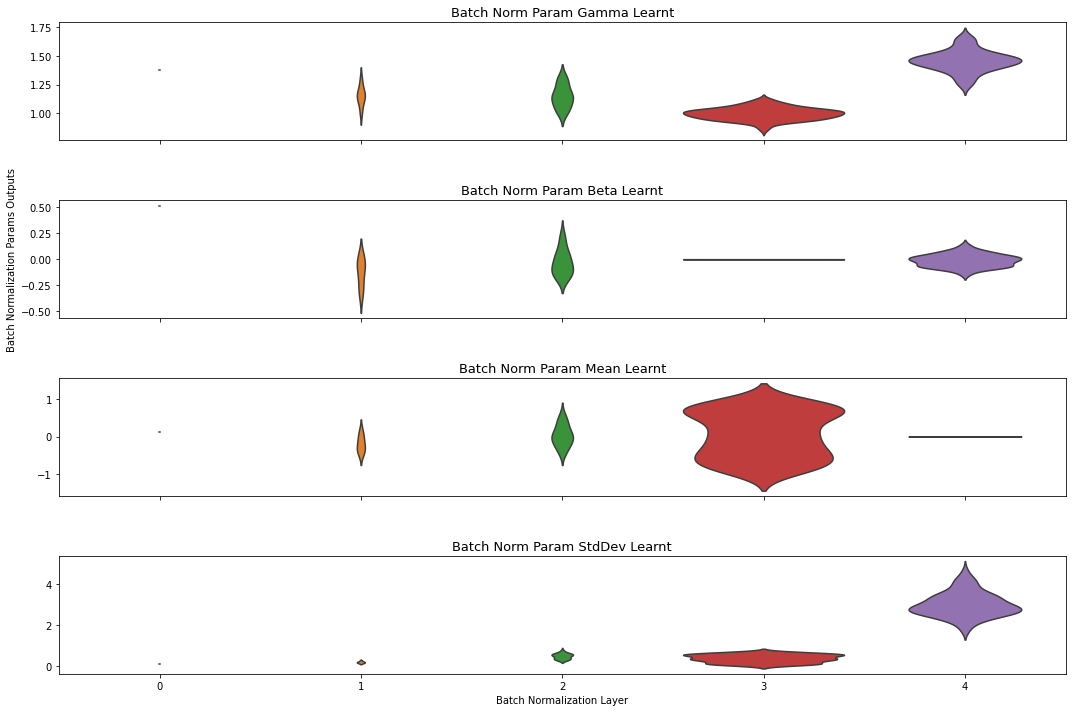

In [ ]:
# Plotting learned batch parameters (gamma, beta, means, std. deviations)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

gammas = [layer.get_weights()[0] for layer in model.layers if 'batch_normalization' in layer.name]
betas = [layer.get_weights()[1] for layer in model.layers if 'batch_normalization' in layer.name]
means = [layer.get_weights()[2] for layer in model.layers if 'batch_normalization' in layer.name]
std_devs = [layer.get_weights()[3] for layer in model.layers if 'batch_normalization' in layer.name]

batch_norm_params = ["Gamma", "Beta", "Mean", "StdDev"]
output_for_all_layers = []

for idx, gamma in enumerate(gammas):
  for gamma_val in gamma.ravel():
    output_for_all_layers.append([batch_norm_params[0], idx, gamma_val])

for idx, beta in enumerate(betas):
  for beta_val in beta.ravel():
    output_for_all_layers.append([batch_norm_params[1], idx, beta_val])

for idx, mean in enumerate(means):
  for mean_val in mean.ravel():
    output_for_all_layers.append([batch_norm_params[2], idx, mean_val])

for idx, std_dev in enumerate(std_devs):
  for std_dev_val in std_dev.ravel():
    output_for_all_layers.append([batch_norm_params[3], idx, std_dev_val])

df = pd.DataFrame(output_for_all_layers, columns=['Param', 'Layer', 'Output'])
fig = plt.figure(figsize=(15, 2.5*len(batch_norm_params)))
axes = grid_axes_it(len(batch_norm_params), 1, fig=fig)

for param in batch_norm_params:
  ax = next(axes)
  ddf = df[df['Param'] == param]
  sns.violinplot(x='Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

  ax.set_xlabel('')
  ax.set_ylabel('')

  ax.set_title(f'Batch Norm Param {param} Learnt', fontsize=13)
    
  if param == batch_norm_params[1]:
    ax.set_ylabel(f"Batch Normalization Params Outputs")
  if param != batch_norm_params[-1]:
    ax.set_xticklabels(())
  else:
    ax.set_xlabel("Batch Normalization Layer")

plt.tight_layout()
plt.show()


<font color="blue">
    If you see the accuracy above, it's very clearly visible that the batch normalization for the input layer case performed way better than taking a standard normalization for the input layer. Why's that the case? Actually, that was predictable because in the case of the standard normalization for the input layer, the mean and variance are computed for the whole training dataset and when this is applied to all the images in the dataset, that would really hamper the image data in this case and the results show that as the accuracy is really less for that case. Howver, when we do the normalization using the batch normalization, first of all it is done for batches and secondly, it learns the parameters which can help in choosing whether to apply some normalization or not. As these are learned values and it happens for each batch, this wouldn't hamper the image data a lot and we get normalized values as well for which the model learns really well thus, giving us an accuracy of even more than 99%. 
</font>

4. Train the network without batch normalization but this time use dropout. For hidden layers use dropout probability of 0.5 and for input layer take it to be 0.2 Compare test accuracy using dropout to test accuracy obtained using batch normalization in part 2 and 3.

## Solution 3.4

In [ ]:
# Create the model with Layer Normalization for the input layer and Batch Normalization layer for all the hidden layer
model = Sequential()

model.add(layers.Input(shape = (28, 28, 1)))
model.add(layers.Dropout(0.2))

# Convolution Layer
model.add(layers.Conv2D(6, kernel_size = (5, 5), strides = (1, 1), padding = "same"))
model.add(layers.Activation(activations.tanh))
model.add(layers.Dropout(0.5))

# Average Pooling Layer
model.add(layers.AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))
model.add(layers.Dropout(0.5))

# Convolution Layer
model.add(layers.Conv2D(16, kernel_size = (5, 5), strides = (1, 1), padding = "valid"))
model.add(layers.Activation(activations.tanh))
model.add(layers.Dropout(0.5))

# Average Pooling Layer
model.add(layers.AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))
model.add(layers.Dropout(0.5))

# Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size = (5, 5), strides = (1, 1), padding = "valid"))
model.add(layers.Activation(activations.tanh))
model.add(layers.Dropout(0.5))

# Flatten the CNN output
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(84))
model.add(layers.Activation(activations.tanh))
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(10, activation = "softmax"))

# Compile a model
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test), verbose = 1)
scores = model.evaluate(x_test, y_test)
print(f"Test Loss : {scores[0]}, Accuracy = {scores[1]*100}%")

Epoch 1/100
59/59 [==============================] - 2s 27ms/step - loss: 1.3405 - accuracy: 0.5471 - val_loss: 0.4578 - val_accuracy: 0.8703
Epoch 2/100
59/59 [==============================] - 1s 21ms/step - loss: 0.8106 - accuracy: 0.7342 - val_loss: 0.3601 - val_accuracy: 0.8962
Epoch 3/100
59/59 [==============================] - 1s 21ms/step - loss: 0.7230 - accuracy: 0.7694 - val_loss: 0.3217 - val_accuracy: 0.9085
Epoch 4/100
59/59 [==============================] - 1s 21ms/step - loss: 0.6697 - accuracy: 0.7877 - val_loss: 0.2965 - val_accuracy: 0.9164
Epoch 5/100
59/59 [==============================] - 1s 21ms/step - loss: 0.6350 - accuracy: 0.7999 - val_loss: 0.2798 - val_accuracy: 0.9215
Epoch 6/100
59/59 [==============================] - 1s 21ms/step - loss: 0.6020 - accuracy: 0.8120 - val_loss: 0.2584 - val_accuracy: 0.9291
Epoch 7/100
59/59 [==============================] - 1s 21ms/step - loss: 0.5742 - accuracy: 0.8196 - val_loss: 0.2475 - val_accuracy: 0.9275
Epoch 

<font color="blue">
    As we can see above, the accuracy is less for the Dropout case when compared to the batch normalization case. For the image data here, it seems that the model performs a little better when we use batch normalization as compared to when we are using the dropout layers. <br>
    References: https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739
    <br>https://link.springer.com/article/10.1007/s11042-019-08453-9
</font>

5. Now train the network using both batch normalization and dropout. How does the performance (test accuracy) of the network compare with the cases with dropout alone and with batch normalization alone ?

## Solution 3.5

In [ ]:
# Create the model with Layer Normalization for the input layer and Batch Normalization layer for all the hidden layer
model = Sequential()

model.add(layers.Input(shape = (28, 28, 1)))
model.add(BatchNormalization(trainable = True))
model.add(layers.Dropout(0.2))

# Convolution Layer
model.add(layers.Conv2D(6, kernel_size = (5, 5), strides = (1, 1), activation = 'tanh', padding = "same"))
model.add(BatchNormalization(trainable = True))
model.add(layers.Dropout(0.5))

# Average Pooling Layer
model.add(layers.AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))
model.add(layers.Dropout(0.5))

# Convolution Layer
model.add(layers.Conv2D(16, kernel_size = (5, 5), strides = (1, 1), activation = 'tanh', padding = "valid"))
model.add(BatchNormalization(trainable = True))
model.add(layers.Dropout(0.5))

# Average Pooling Layer
model.add(layers.AveragePooling2D(pool_size = (2, 2), strides = (2, 2), padding = "valid"))
model.add(layers.Dropout(0.5))

# Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size = (5, 5), strides = (1, 1), activation = 'tanh', padding = "valid"))
model.add(BatchNormalization(trainable = True))
model.add(layers.Dropout(0.5))

# Flatten the CNN output
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(84))
model.add(BatchNormalization(trainable = True))
model.add(layers.Activation(activations.tanh))
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(10, activation = "softmax"))

# Compile a model
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test), verbose = 1)
scores = model.evaluate(x_test, y_test)
print(f"Test Loss : {scores[0]}, Accuracy = {scores[1]*100}%")

Epoch 1/100
59/59 [==============================] - 3s 33ms/step - loss: 1.3186 - accuracy: 0.5581 - val_loss: 0.9609 - val_accuracy: 0.6419
Epoch 2/100
59/59 [==============================] - 2s 29ms/step - loss: 0.7749 - accuracy: 0.7503 - val_loss: 0.8340 - val_accuracy: 0.7004
Epoch 3/100
59/59 [==============================] - 2s 29ms/step - loss: 0.6497 - accuracy: 0.7927 - val_loss: 0.7529 - val_accuracy: 0.7365
Epoch 4/100
59/59 [==============================] - 2s 29ms/step - loss: 0.5778 - accuracy: 0.8177 - val_loss: 0.7017 - val_accuracy: 0.7645
Epoch 5/100
59/59 [==============================] - 2s 29ms/step - loss: 0.5279 - accuracy: 0.8342 - val_loss: 0.6564 - val_accuracy: 0.7794
Epoch 6/100
59/59 [==============================] - 2s 29ms/step - loss: 0.4880 - accuracy: 0.8466 - val_loss: 0.5649 - val_accuracy: 0.7997
Epoch 7/100
59/59 [==============================] - 2s 29ms/step - loss: 0.4522 - accuracy: 0.8584 - val_loss: 0.4865 - val_accuracy: 0.8229
Epoch 

<font color="blue">
    For the above case, when we use both the batch normalization and the dropout layers, it's clearly visible that this also performs a little worser (accuracy and loss comparison, accuracy is lower and the loss is higher) when compared to the case of Batch Normalization only. However, it performs a little better when compared to the case of just using the dropout layers. Thus, it can be clearly inferred that for this image data, the batch normalization would be a better technique to maximize the model performance and get the best results possible.
</font>

## Problem 4

1. Assume that total budget for number of hidden units we can have in the network is 512. Train a 1, 2, and 3 hidden layers feedforward neural network to learn the regression function. For each neural network you can consider a different number of hidden units per hidden layer so that the total number of hidden units does not exceed 512. We would recommend to work with 16, 32, 64, 128, 256, 512, hidden units per layer. So if there is only one hidden layer you can have at most 512 units in that layer. If there are two hidden layers, you can have any combination of hidden units in each layer, e.g., 16 and 256, 64 and 128, etc. such that the total is less than 512. Plot the RMSE (Root Mean Square Error) on test set for networks with different number of hidden layers as a function of total number of hidden units. If there are more than one network with the same number of hidden units (say a two hidden layer with 16 in first layer and 128 in second layer and another network with 128 in first layer and 16 in second) you will use the average RMSE. So you will have a figure with three curves, one each for 1, 2, and 3 layer networks, with x-axis being the total number of hidden units. Also plot another curve but with the x-axis being the number of parameters (weights) that you need to learn in the network.

## Solution 4.1

In [ ]:
import math
import numpy as np
import pandas as pd

def func_x1_x2(x1, x2):
  part_1 = -(x2 + 47)*np.sin(math.sqrt(abs((x1 / 2) + (x2 + 47))))
  part_2 = -x1*np.sin(math.sqrt(abs(x1 - (x2 + 47))))

  return part_1 + part_2


In [ ]:
# Generating Dataset
np.random.seed(12121)

x1_vals = list(range(-512, 513, 10))[:100]
np.random.shuffle(x1_vals)
x2_vals = list(range(-512, 513, 10))[:100]
np.random.shuffle(x2_vals)

x_pairs = []
f_values = []
y_values = []

for x1 in x1_vals:
  for x2 in x2_vals:
    x_pairs.append([x1, x2])
    f_values.append(func_x1_x2(x1, x2))

normal_values = np.random.normal(0, 0.3, 10000)
y_values = f_values + normal_values


In [ ]:
# Generating Train and Test Splits Data
x_train = x_pairs[:int(0.8*len(x_pairs))]
x_test = x_pairs[int(0.8*len(x_pairs)):]
y_train = y_values[:int(0.8*len(y_values))]
y_test = y_values[int(0.8*len(y_values)):]

x1_train = [x[0] for x in x_train]
x1_train = [(float(x) - min(x1_train))/(max(x1_train) - min(x1_train)) for x in x1_train]
x2_train = [x[1] for x in x_train]
x2_train = [(float(x) - min(x2_train))/(max(x2_train) - min(x2_train)) for x in x2_train]
x1_test = [x[0] for x in x_test]
x1_test = [(float(x) - min(x1_test))/(max(x1_test) - min(x1_test)) for x in x1_test]
x2_test = [x[1] for x in x_test]
x2_test = [(float(x) - min(x2_test))/(max(x2_test) - min(x2_test)) for x in x2_test]
x_train = np.stack([x1_train, x2_train], axis = 1)
x_test = np.stack([x1_test, x2_test], axis = 1)

y_train = [(float(y) - min(y_train))/(max(y_train) - min(y_train)) for y in y_train]
y_test = [(float(y) - min(y_test))/(max(y_test) - min(y_test)) for y in y_test]


In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras import activations, Input
from tensorflow.keras.metrics import RootMeanSquaredError
import keras

def generate_model(hidden_layer_1_units_num, hidden_layer_2_units_num = None, hidden_layer_3_units_num = None):
  model = Sequential()

  model.add(layers.Dense(hidden_layer_1_units_num, input_dim = 2, activation = 'relu'))

  if hidden_layer_2_units_num is not None:
    model.add(layers.Dense(hidden_layer_2_units_num, activation = 'relu'))
    model.add(BatchNormalization(trainable = True))
  
  if hidden_layer_3_units_num is not None:
    model.add(layers.Dense(hidden_layer_3_units_num, activation = 'relu'))
    model.add(BatchNormalization(trainable = True))

  model.add(layers.Dense(1, activation='linear'))

  return model


In [ ]:
from keras import backend as K
import time

def train_model_and_compute_params(x_train, y_train, x_test, y_test,
                                   hidden_layer_1_units_num, hidden_layer_2_units_num = None, hidden_layer_3_units_num = None):
  print("Creating and Training a Model:\n")
  start = time.time()
  model = generate_model(hidden_layer_1_units_num, hidden_layer_2_units_num, hidden_layer_3_units_num)
  optimizer = optimizers.SGD(nesterov = True)
  model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = [RootMeanSquaredError()])

  history = model.fit(x_train, y_train, epochs = 2000, batch_size = 1000, validation_data = (x_test, y_test), verbose = 1)
  end = time.time()
  score = model.evaluate(x_test, y_test)
  print(f"Test Loss (RMSE): {score[1]}")

  trainable_params_count = int(np.sum([K.count_params(trainable_weights) for trainable_weights in set(model.trainable_weights)]))

  return score[1], trainable_params_count, end - start

In [ ]:
hidden_units_per_layer = [16, 32, 64, 128, 256, 512]
hidden_units_budget = 512
# Assumption: I am taking only a subset of the permutations here.
# As when I asked "Parijat Dube", he told to generate only a few of them (10-15 in total).
def get_permutations_of_hidden_units():
  perms_1 = []
  perms_2 = []
  perms_3 = []

  for hidden_unit in hidden_units_per_layer:
    perms_1.append([hidden_unit])
  
  for idx in range(len(hidden_units_per_layer)):
    if idx == len(hidden_units_per_layer) - 1:
      continue
    if idx == 0:
      perms_2.append([hidden_units_per_layer[idx], hidden_units_per_layer[idx]])
      perms_2.append([hidden_units_per_layer[idx + 1], hidden_units_per_layer[idx]])
      continue
    if idx == len(hidden_units_per_layer) - 2:
      perms_2.append([hidden_units_per_layer[idx], hidden_units_per_layer[idx]])
      continue
    
    perms_2.append([hidden_units_per_layer[idx + 1], hidden_units_per_layer[idx]])

  for idx in range(len(hidden_units_per_layer)):
    if idx == len(hidden_units_per_layer) - 2:
      break
    perms_3.append([hidden_units_per_layer[idx], hidden_units_per_layer[idx], hidden_units_per_layer[idx]])

    if hidden_units_per_layer[idx] + hidden_units_per_layer[idx + 1] + hidden_units_per_layer[idx + 2] > hidden_units_budget:
      continue
    perms_3.append([hidden_units_per_layer[idx + 2], hidden_units_per_layer[idx + 1], hidden_units_per_layer[idx]])

  return perms_1, perms_2, perms_3

In [ ]:
perms_1, perms_2, perms_3 = get_permutations_of_hidden_units()

In [ ]:
def run_models_for_one_set_of_hidden_layers(perms_hidden_layers):
  hidden_units_loss_map = dict()
  train_params_loss_map = dict()
  train_params_train_time_map = dict()

  for perm_hidden_layer in perms_hidden_layers:
    loss, trainable_params, training_time = train_model_and_compute_params(x_train, y_train, x_test, y_test,
                                                                          perm_hidden_layer[0],
                                                                          perm_hidden_layer[1] if len(perm_hidden_layer) > 1 else None,
                                                                          perm_hidden_layer[2] if len(perm_hidden_layer) > 2 else None)
    total_hidden_units = perm_hidden_layer[0] + \
                        (perm_hidden_layer[1] if len(perm_hidden_layer) > 1 else 0) + \
                        (perm_hidden_layer[2] if len(perm_hidden_layer) > 2 else 0)
    
    hidden_units_loss_map[total_hidden_units] = loss
    train_params_loss_map[trainable_params] = loss
    train_params_train_time_map[trainable_params] = training_time

  return hidden_units_loss_map, train_params_loss_map, train_params_train_time_map

In [ ]:
hidden_units_loss_map_1, train_params_loss_map_1, train_params_train_time_map_1 = run_models_for_one_set_of_hidden_layers(perms_1)

Streaming output truncated to the last 5000 lines.
8000/8000 [==============================] - 0s 6us/sample - loss: 0.0202 - root_mean_squared_error: 0.1420 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1526
Epoch 1505/2000
8000/8000 [==============================] - 0s 6us/sample - loss: 0.0201 - root_mean_squared_error: 0.1417 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529
Epoch 1506/2000
8000/8000 [==============================] - 0s 6us/sample - loss: 0.0202 - root_mean_squared_error: 0.1422 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1591
Epoch 1507/2000
8000/8000 [==============================] - 0s 6us/sample - loss: 0.0203 - root_mean_squared_error: 0.1424 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1524
Epoch 1508/2000
8000/8000 [==============================] - 0s 6us/sample - loss: 0.0204 - root_mean_squared_error: 0.1428 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1545
Epoch 1509/2000
8000/8000 [==============================] -

In [ ]:
hidden_units_loss_map_2, train_params_loss_map_2, train_params_train_time_map_2 = run_models_for_one_set_of_hidden_layers(perms_2)

Streaming output truncated to the last 5000 lines.
8000/8000 [==============================] - 0s 7us/sample - loss: 0.0221 - root_mean_squared_error: 0.1486 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1600
Epoch 1505/2000
8000/8000 [==============================] - 0s 8us/sample - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1635
Epoch 1506/2000
8000/8000 [==============================] - 0s 8us/sample - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1298
Epoch 1507/2000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1262
Epoch 1508/2000
8000/8000 [==============================] - 0s 8us/sample - loss: 0.0126 - root_mean_squared_error: 0.1122 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 1509/2000
8000/8000 [==============================] -

In [ ]:
perms_3.append([128, 128, 256]) # 1 Additional case to scale the data in the full range.
hidden_units_loss_map_3, train_params_loss_map_3, train_params_train_time_map_3 = run_models_for_one_set_of_hidden_layers(perms_3)

Streaming output truncated to the last 5000 lines.
8000/8000 [==============================] - 0s 13us/sample - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1111
Epoch 1505/2000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0980
Epoch 1506/2000
8000/8000 [==============================] - 0s 10us/sample - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917
Epoch 1507/2000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0060 - root_mean_squared_error: 0.0775 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1026
Epoch 1508/2000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0911
Epoch 1509/2000
8000/8000 [==============================]

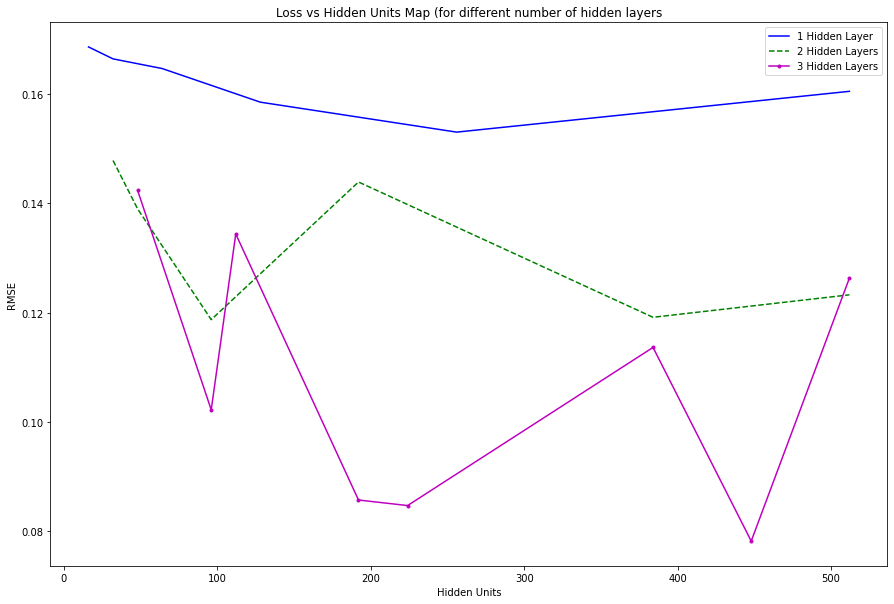

In [ ]:
import matplotlib.pyplot as plt

lists_1 = sorted(hidden_units_loss_map_1.items())
x_1, y_1 = zip(*lists_1)

lists_2 = sorted(hidden_units_loss_map_2.items())
x_2, y_2 = zip(*lists_2)

lists_3 = sorted(hidden_units_loss_map_3.items())
x_3, y_3 = zip(*lists_3)

plot1, = plt.plot(x_1, y_1, '-', color='b')
plot2, = plt.plot(x_2, y_2, '--', color='g')
plot3, = plt.plot(x_3, y_3, '.-', color = 'm')
plt.legend([plot1, plot2, plot3], ['1 Hidden Layer', '2 Hidden Layers', '3 Hidden Layers'])
plt.rcParams["figure.figsize"] = (15, 10)
plt.xlabel('Hidden Units')
plt.ylabel('RMSE')
plt.title('Loss vs Hidden Units Map (for different number of hidden layers')
plt.show()


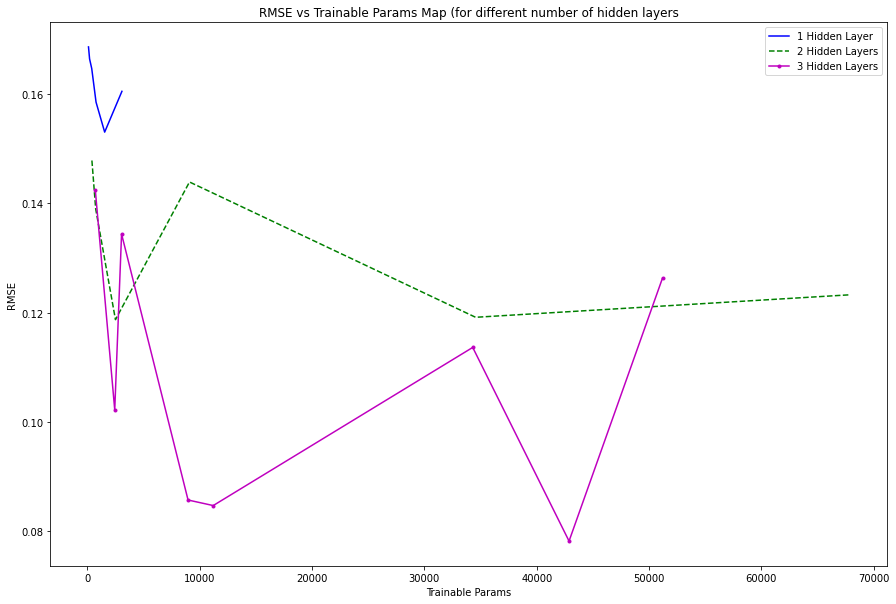

In [ ]:
import matplotlib.pyplot as plt

lists_1 = sorted(train_params_loss_map_1.items())
x_1, y_1 = zip(*lists_1)

lists_2 = sorted(train_params_loss_map_2.items())
x_2, y_2 = zip(*lists_2)

lists_3 = sorted(train_params_loss_map_3.items())
x_3, y_3 = zip(*lists_3)

plot1, = plt.plot(x_1, y_1, '-', color='b')
plot2, = plt.plot(x_2, y_2, '--', color='g')
plot3, = plt.plot(x_3, y_3, '.-', color = 'm')
plt.legend([plot1, plot2, plot3], ['1 Hidden Layer', '2 Hidden Layers', '3 Hidden Layers'])
plt.rcParams["figure.figsize"] = (15, 10)
plt.xlabel('Trainable Params')
plt.ylabel('RMSE')
plt.title('RMSE vs Trainable Params Map (for different number of hidden layers')
plt.show()


2. Comment on the tradeoff between number of parameters and RMSE as you go from deeper (3 hidden layers) to shallow networks (1 hidden layer). Also measure the wall clock time for training each config- uration and plot training time vs number of parameters. Do you see a similar tradeoff in training time ? 

## Solution 4.2

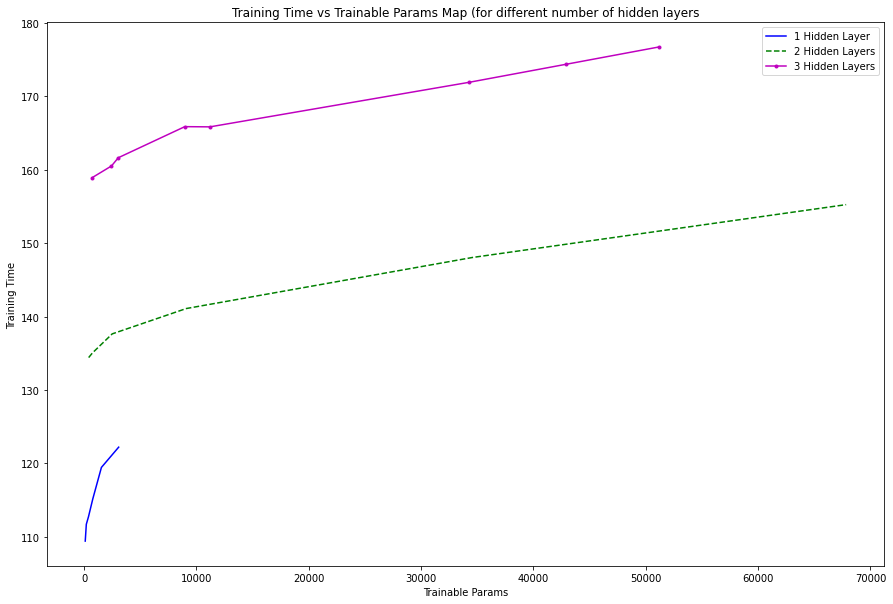

In [ ]:
import matplotlib.pyplot as plt

lists_1 = sorted(train_params_train_time_map_1.items())
x_1, y_1 = zip(*lists_1)

lists_2 = sorted(train_params_train_time_map_2.items())
x_2, y_2 = zip(*lists_2)

lists_3 = sorted(train_params_train_time_map_3.items())
x_3, y_3 = zip(*lists_3)

plot1, = plt.plot(x_1, y_1, '-', color='b')
plot2, = plt.plot(x_2, y_2, '--', color='g')
plot3, = plt.plot(x_3, y_3, '.-', color = 'm')
plt.legend([plot1, plot2, plot3], ['1 Hidden Layer', '2 Hidden Layers', '3 Hidden Layers'])
plt.rcParams["figure.figsize"] = (15, 10)
plt.xlabel('Trainable Params')
plt.ylabel('Training Time')
plt.title('Training Time vs Trainable Params Map (for different number of hidden layers')
plt.show()


<font color="blue">
    For the RMSE vs. trainable parameters plot above, when we consider only 1 hidden layer, there is not much change in the RMSE and thus, there is not much decrease in the loss and increase in the model performance. When we consider 2 hidden layers, the RMSE seems to drop a little, but still the number of parameters have to increase by a lot to get that changes in the RMSE which is not as significant as the increase in the number of trainable parameters. However, when we consider 3 hidden layers, the change in RMSE is quite high for some of the cases and it seems to be a downward trend where we can see that the RMSE decreases as the number of trainabale parameters increase and the hidden units increase. The change in RMSE is quite significant here. However, it might be debatable as to the increase in the number of trainable parameters, it's a good deal or not. According to me it isn't, as we have just halved the RMSE by increasing the number of trainable parameters by about 9 times. <br>
    For the training time vs. trainable parameters plot above, when we consider only 1 hidden layer case, the rate of increase of the training time with the increase in the trainable parameters is quite high. So, just increasing the number of hidden units for 1 layer (which in turn increases the number of trainable parameters for this case), wouldn't actually help a lot as the training time increases by a lot. When we consider the case when we either have 2 hidden layer or 3 hidden layers, the initial increase in the training time is quite large. However, for those cases, when we increase the trainable parameters, the rate of increase in training time is less and it increases in a linear fashion. As the rate of increase is not very high, I might say that increasing the number of trainable parameters for 2-3 hidden layer models wouldn't impact the training time significantly. However, if we would extend this graph beyond, it might look that the training time is increasing by a lot but in comparison to the increase in the trainable parameters, it's quite less still!
</font>

<h2><center> END OF ASSIGNMENT - Chandan Suri - CS4090 </center></h2>